<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Project%201/Deep_Learning_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep Learning model that can identify the state of different cooking ingredients

#submit accuracy/loss figures for each epoch for both training and validation data

#https://www.tensorflow.org/tutorials/images/classification

#focus on getting a working model for pt 2. try a simple one first, then gradually increase complexity until we acheive overfitting. submit accuracy/loss figures for this part
#pt3 is all about hyperparameter tuning/data augmentation


#Run these commands - NECCESARY to use the GPU
#export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
#export LD_LIBRARY_PATH=${CUDNN_PATH}/lib

#To connect to local runtime: jupyter lab --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

# Loading Data

In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt
import PIL
from tensorflow import keras

In [ ]:
#Some hyperparameter setup
image_size = (160, 160)   #set image size to 160 x 160
batch_size = 256           #set batch size to 256
epochs = 150               #set num epochs to 150
label_mode = 'int' #'categorical' uses categorical_crossentropy , 'int' uses sparse_categorical_crossentropy
num_classes = 11

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
data_dir = 'Deep Learning/Project 1/'

import os
print(os.getcwd())

Num GPUs Available:  1
/home/ckantor


2024-03-10 21:10:26.697817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:26.727452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:26.727508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
#load data set
#Loading training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'data/train/',
    batch_size = None,
    label_mode = label_mode,
    seed = 8312001,
)

#Loading validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'data/valid',
    batch_size = None,
    label_mode = label_mode,
    seed = 8312001
)

Found 7213 files belonging to 11 classes.


2024-03-10 21:10:27.477889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:27.477993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:27.478027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:27.647249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 21:10:27.647305: I external/local_xla/xla/stream_executor

Found 1543 files belonging to 11 classes.


In [ ]:
#image resizing and data augmentation
#resize and normalize the images to 160 x 160 with values between 0-1
#apply data augmentation to the TRANING set ONLY
AUTOTUNE = tf.data.AUTOTUNE   #use autotune to overlap data preprocessing on the CPU while training on the GPU

#resize and scale our input images to 160 x 160 with values between 0 and 1
resize_and_rescale = keras.Sequential([
    tf.keras.layers.Resizing(image_size[0], image_size[1]),
    tf.keras.layers.Rescaling(1./255)
])

#our data augmentation pipeline. Randomly flips the image horizontally and vertically and changes the brightness
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  # tf.keras.layers.RandomBrightness(factor = 0.2, value_range = [0.0, 1.0]),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3)
])



#apply these normalizations and augments to the training and validation datasets
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)

# Model Creating and Training

In [ ]:
#Our residual connection layer. The same as the residual connections from original ResNet paper
#we use batch normalization after every convolution and before our activation functions like the paper suggests
#https://arxiv.org/pdf/1512.03385.pdf

def res_block(input, num_filters, kernel_size, strides=(1, 1)):
  resized_input = input

  #if the input has a different number of layers than the output, project the input using a 1x1 convolution to the correct number of layers
  if input.shape[-1] != num_filters:
    resized_input = tf.keras.layers.Conv2D(num_filters, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(input)

  first_conv = tf.keras.layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same') (input)
  first_conv = tf.keras.layers.BatchNormalization() (first_conv)
  first_conv = tf.keras.layers.ReLU() (first_conv)

  second_conv = tf.keras.layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same') (first_conv)
  second_conv = tf.keras.layers.BatchNormalization() (second_conv)
  second_conv = tf.keras.layers.ReLU() (second_conv)

  out = tf.keras.layers.Add()([resized_input, second_conv])
  out = tf.keras.layers.ReLU() (out)
  return out



#our inception block. Based on the inception paper by Google: https://paperswithcode.com/method/inception-module
#reduce 3x3, 5x5, and pool represent the number of filters in the output of the 1x1 layer before the 3x3/5x5 convolutions (or after the pooling layer)
def inception_block(input, filter1x1, filter3x3, filter5x5, reduce3x3, reduce5x5, reducepool):
  #1x1 convolution
  conv1x1 = tf.keras.layers.Conv2D(filter1x1, kernel_size=(1,1), padding='same', activation='relu') (input)

  #3x3 convolution
  conv3x3 = tf.keras.layers.Conv2D(reduce3x3, kernel_size=(3,3), padding='same', activation='relu') (input)
  conv3x3 = tf.keras.layers.Conv2D(filter3x3, kernel_size=(3,3), padding='same', activation='relu') (conv3x3)

  #5x5 convolution
  conv5x5 = tf.keras.layers.Conv2D(reduce5x5, kernel_size=(5,5), padding='same', activation='relu') (input)
  conv5x5 = tf.keras.layers.Conv2D(filter5x5, kernel_size=(5,5), padding='same', activation='relu') (conv5x5)

  #3x3 max pooling convo
  pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same') (input)
  pool = tf.keras.layers.Conv2D(reducepool, kernel_size=(1,1), padding='same', activation='relu') (pool)

  #concat all the layers
  out = tf.keras.layers.concatenate([conv1x1, conv3x3, conv5x5, pool])
  return out

In [ ]:
inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3), name="img")

#Best model found. Uses 3 residual blocks followed by an inception block.
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
x = tf.keras.layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), activation='relu', kernel_regularizer=tf.keras.regularizers.L2()) (inputs)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.MaxPooling2D() (x)
x = res_block(x, 64, 5)
x = tf.keras.layers.MaxPooling2D() (x)
x = res_block(x, 128, 5)
x = tf.keras.layers.MaxPooling2D() (x)
x = res_block(x, 256, 3)
x = tf.keras.layers.MaxPooling2D() (x)
x = inception_block(x, 64, 128, 32, 128, 16, 32)
x = tf.keras.layers.Flatten() (x)
x = tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()) (x)
x = tf.keras.layers.Dropout(0.5) (x)
output = tf.keras.layers.Dense(num_classes) (x)

model = keras.Model(inputs, output, name="ResInceptionNet")

Model: "ResInceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 77, 77,    │      9,472 │ img[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 77, 77,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 38, 38,    │    102,464 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │    102,464 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 38, 38,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 19, 19,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 19, 19,    │    204,928 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 19, 19,    │    409,728 │ re_lu_3[0][0]   

 Total params: 2,859,291 (10.91 MB)

 Trainable params: 2,857,371 (10.90 MB)

 Non-trainable params: 1,920 (7.50 KB)

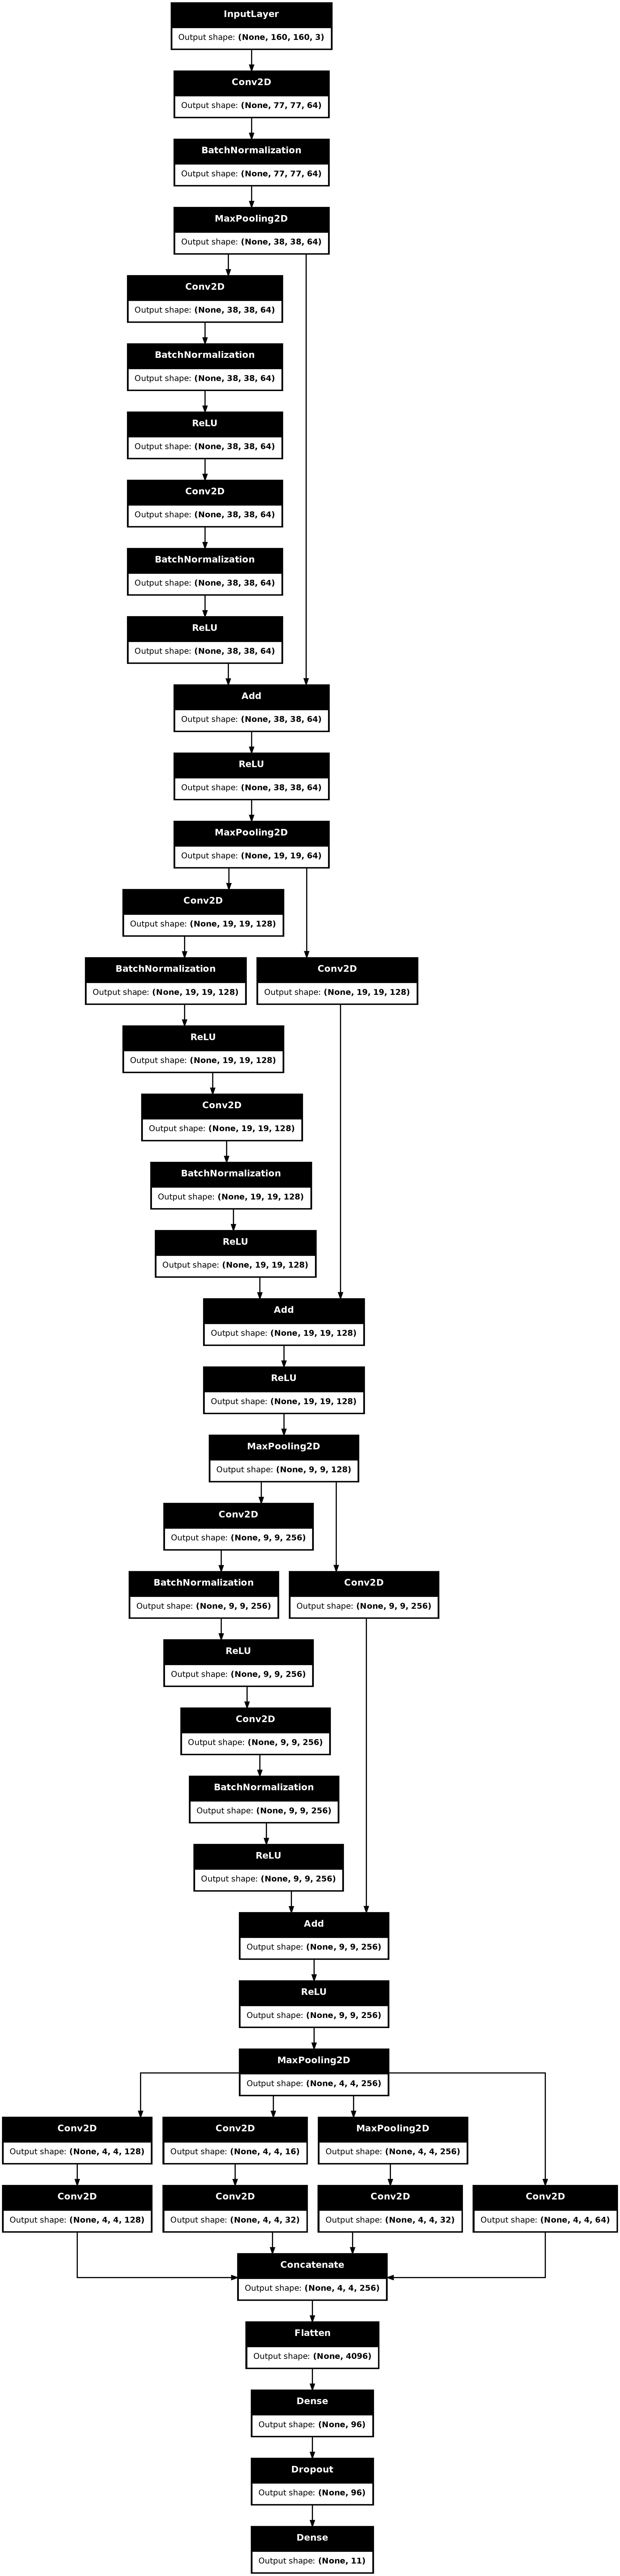

In [ ]:
#our learning rate scheduler. Will gradually shrink the learning rate as training progesses to find a better converging point.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-7)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, "ResInceptionNet.png", show_shapes=True)

In [ ]:
#save best model
checkpoint_path = "Deep Learning/Project 1/checkpoints/model2/bestWeights.keras"

#pick the model highest validation accuracy during training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#early stopping callback. stop if the loss doesn't improve for 7 epochs in a row
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=7,
    start_from_epoch=20)

#train the model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/150


I0000 00:00:1710117199.104995  178214 service.cc:145] XLA service 0x7f7d0c0103c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710117199.105074  178214 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-10 20:33:19.571794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 20:33:21.022413: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1710117218.107308  178214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 537ms/step - accuracy: 0.1074 - loss: 5.3059 - val_accuracy: 0.1128 - val_loss: 4.1690
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.1264 - loss: 4.0976 - val_accuracy: 0.1134 - val_loss: 3.9063
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.1208 - loss: 3.8298 - val_accuracy: 0.1134 - val_loss: 3.6611
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.1241 - loss: 3.5480 - val_accuracy: 0.1089 - val_loss: 3.3961
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.1263 - loss: 3.3065 - val_accuracy: 0.0940 - val_loss: 3.1781
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.1364 - loss: 3.1037 - val_accuracy: 0.0979 - val_loss: 3.0864
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.1316 - loss: 2.9495 - val_accuracy: 0.1536 - val_loss: 2.8498
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.1371 - loss: 2.8209 - val_accuracy: 0.15

NameError: name 'checkpoint_filepath' is not defined

In [ ]:
#load the best model using the callback
model.load_weights(checkpoint_path)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data [loss, acc]
model.evaluate(valid_ds, verbose=2)



Evaluating Best Model

7/7 - 1s - 168ms/step - accuracy: 0.5878 - loss: 1.4888


[1.488770604133606, 0.5878159403800964]

In [ ]:
print(history.history)
#save the model
model.save("Deep Learning/Project 1/bestModel_ResInceptionNet.keras")
print("Saved Model")

{'accuracy': [0.11312907189130783, 0.12948842346668243, 0.1207541972398758, 0.12463607639074326, 0.1261610984802246, 0.1350339651107788, 0.1340634971857071, 0.1387772113084793, 0.13974767923355103, 0.13489532470703125, 0.14376819133758545, 0.1422431766986847, 0.14446139335632324, 0.1452932208776474, 0.15458200871944427, 0.17510052025318146, 0.16525717079639435, 0.17759600281715393, 0.1868847906589508, 0.19686676561832428, 0.19284625351428986, 0.21086926758289337, 0.22833772003650665, 0.2329127937555313, 0.2284763604402542, 0.2431720495223999, 0.25772911310195923, 0.2793567180633545, 0.28947731852531433, 0.303618460893631, 0.29959794878959656, 0.32344377040863037, 0.33980312943458557, 0.360876202583313, 0.3836129307746887, 0.3809787929058075, 0.38416746258735657, 0.4037155210971832, 0.4109247326850891, 0.4081519544124603, 0.42991819977760315, 0.43504783511161804, 0.43643420934677124, 0.449604868888855, 0.4557049870491028, 0.46028006076812744, 0.4629141688346863, 0.4685983657836914, 0.46

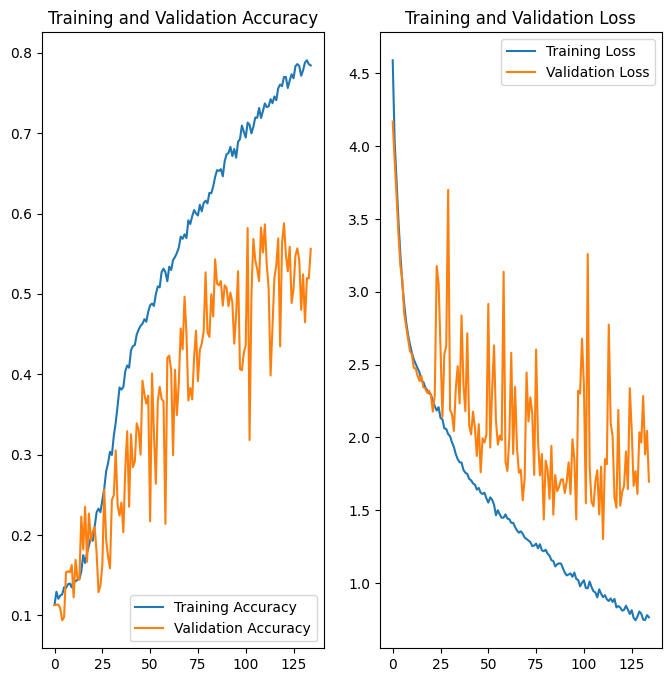

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(min(epochs, len(acc)))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing Script

In [4]:
#load pretrained model and test it on a loaded test dataset to verify results
## Mount Google drive
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt





# ## Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 1/'


#############################################################################
########################ASSUMPTIONS ON FILE STRUCTURE########################
#assuming model and test folder are in the same directory, and the ground truth file is inside the test folder


#load the model from a saved file
model = tf.keras.models.load_model("bestModel_ResInceptionNet.keras")
model.summary()
tf.keras.utils.plot_model(model, "ResInceptionNet.png", show_shapes=True)

#create array representing our labels
label_names = ['creamy_paste', 'diced', 'floured', 'grated', 'juiced', 'julienne', 'mixed', 'other', 'peeled', 'sliced', 'whole']



#if we have a ground truth file, use it to get the names of the images
# #read in the ground truth json in the test folder which holds the labels for each file
# testData = pd.read_json('test/ground_truth.json', orient='index').reset_index()
# testData.columns = ['Image Name', 'Label']
#now we a dataframe with two columns. The first column holds the name of each image, and the second column holds the label for that image that we parsed from the provided json file



#otherwise iterate through the folder and save the image names to an array
test_imgs = []

#use the os library to iterate through all files in the current path
for (root,dirs,files) in os.walk('data/test_real/anonymous', topdown=True):
  for f in files:
    if f.endswith(".jpg"):
      test_imgs.append(f)

print(len(test_imgs))
print(test_imgs[0:20])

Model: "model2_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 77, 77,    │      9,472 │ img[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 38, 38,    │    102,464 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 38, 38,    │    102,464 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 38, 38,    │          0 │ max_pooling2d_8[… │
│                     │ 64)               │            │ re_lu_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 38, 38,    │          0 │ add_6[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 19, 19,    │          0 │ re_lu_20[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 19, 19,    │    204,928 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 19, 19,    │    409,728 │ re_lu_21[0][0]  

 Total params: 8,574,034 (32.71 MB)

 Trainable params: 2,857,371 (10.90 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 5,714,743 (21.80 MB)

1000
['0634.jpg', '0637.jpg', '0120.jpg', '0737.jpg', '0479.jpg', '0242.jpg', '0366.jpg', '0102.jpg', '0167.jpg', '0446.jpg', '0807.jpg', '0997.jpg', '0838.jpg', '0502.jpg', '0206.jpg', '0053.jpg', '0251.jpg', '0766.jpg', '0491.jpg', '0346.jpg']


In [3]:
#save our ouput to a json file line by line
with open('output.json', 'w') as f:
  f.write('{\n')    #write opening bracket

  #if we have a ground truth file
  # for index, row in testData.iterrows():
  #   imgName = row['Image Name']
  #   img = tf.io.read_file('data/test_real/anonymous/' + imgName)
  #   img = tf.io.decode_jpeg(img)
  #   img = tf.image.convert_image_dtype(img, tf.float32)   #convert image values from 0-255 to 0-1
  #   img = tf.image.resize(img, [160, 160])    #resize image to 160 x 160, the same size used during training

  #if we do not
  for imgName in test_imgs:
    img = tf.io.read_file('data/test_real/anonymous/' + imgName)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)   #convert image values from 0-255 to 0-1
    img = tf.image.resize(img, [160, 160])    #resize image to 160 x 160, the same size used during training


    #expand the image and make a prediction
    img = (np.expand_dims(img,0))
    prediction = model.predict(img)

    #write the filename and our prediction to our output json file
    f.write(f'    "{imgName}": "{label_names[np.argmax(prediction[0])]}",\n')

  f.write('}')      #write closing bracket

I0000 00:00:1711366497.566280    5352 service.cc:145] XLA service 0x7f344000f6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711366497.566325    5352 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-25 07:34:57.601415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 07:34:57.763127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


I0000 00:00:1711366499.060970    5352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [ ]:
#Finding testing accuracy

#count how many times each label appears
truth_map = {}
predict_map = {}
total = 0.0
correct = 0.0

with open('test/ground_truth.json') as truth_file, open('output.json') as predict_file:
    for truth, predict in zip(truth_file, predict_file):
      #clean string
      truth_label = [s for s in truth if s.isalnum() or s.isspace()]
      truth_label = "".join(truth_label)

      predict_label = [s for s in predict if s.isalnum() or s.isspace()]
      predict_label = "".join(predict_label)

      if truth_label == predict_label and truth_label != '':
        correct += 1


      truth_label = truth_label.split()
      predict_label = predict_label.split()

      if len(truth_label) == 0 or len(predict_label) == 0:
        continue

      total += 1

      if truth_label[1] not in truth_map.keys():
        truth_map[truth_label[1]] = 1

      else:
        truth_map[truth_label[1]] += 1

      if predict_label[1] not in predict_map.keys():
        predict_map[predict_label[1]] = 1

      else:
        predict_map[predict_label[1]] += 1



print(f'\nTruth Labels:')
print(truth_map)
print(f'\npredict Labels:')
print(predict_map)
print(f'\nTotal Labels: {total}, Correct Labels: {correct}, acc: {correct/total}')



#Best models so far - bestModel_ResInceptionNet w/ test acc of 0.511


Truth Labels:
{'floured': 42, 'whole': 54, 'sliced': 90, 'grated': 37, 'other': 53, 'peeled': 29, 'juiced': 57, 'creamypaste': 36, 'diced': 46, 'mixed': 40, 'jullienne': 36}

predict Labels:
{'floured': 53, 'whole': 40, 'sliced': 117, 'grated': 39, 'other': 35, 'juiced': 42, 'julienne': 49, 'diced': 31, 'peeled': 23, 'creamypaste': 48, 'mixed': 43}

Total Labels: 520.0, Correct Labels: 266.0, acc: 0.5115384615384615
